# Import de fonctions

In [ ]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_wine
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import sys

# import UCSL github : Unsupervised Clustering driven by Supervised Learning 
!git clone https://github.com/rlouiset/py_ucsl > /dev/null 2>&1

sys.path.append('./py_ucsl/')
from ucsl.ucsl_classifier import *
from ucsl.ucsl_regressor import *


# Import data

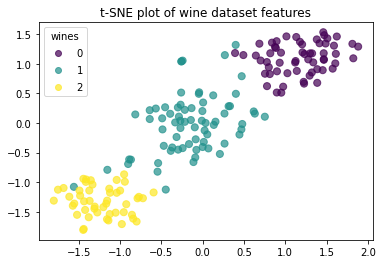

In [ ]:
# load iris dataset
wine = load_wine()
X_train = wine.data

# normalize training features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
y_train = wine.target

# project both on tSNE
tsne = TSNE(n_components=2)
X_train_tsne = tsne.fit_transform(X_train)
X_train_tsne = scaler.fit_transform(X_train_tsne)

# plot t-SNE feature projection
fig, ax = plt.subplots()
labels_map = {0:"0", 1: "1", 2:"2"}
labels = [labels_map[y_i] for y_i in y_train]
scatter = ax.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train, s=50, alpha=0.7, label=labels)
ax.legend(*scatter.legend_elements(), title="wines")
plt.title("t-SNE plot of wine dataset features")
plt.show()

# Wine unsupervised classification

In [ ]:
# one by one separate one flower form the two other, cluster the two other and check the supervised metrics
for neg_label in [0, 1, 2] :
  if neg_label == 0 :
    pos_label=1
    training_label_mapping={0:0, 1:1, 2:1}
    mapping={0:None, 1:1, 2:0}
  if neg_label == 1 :
    pos_label=0
    training_label_mapping={0:0, 1:1, 2:0}
    mapping={0:0, 1:None, 2:1}
  if neg_label == 2 :
    pos_label=0
    training_label_mapping={0:0, 1:0, 2:1}
    mapping={0:0, 1:1, 2:None}

  print("The label not to cluster is : ", neg_label)

  # original HYDRA training
  HYDRA_method = UCSL_C(C=0.1, initialization="DPP", clustering="HYDRA", consensus="spectral_clustering", training_label_mapping=training_label_mapping,
                      n_labels=2, n_consensus=50, n_iterations=20, n_clusters_per_label={0:2, 1:2}, positive_weighting='hard_clustering', negative_weighting='all')

  HYDRA_method = HYDRA_method.fit(X_train, y_train)

  # UCSL training
  UCSL_method = UCSL_C(C=0.1, initialization="gaussian_mixture", clustering="gaussian_mixture", maximization="logistic", consensus="spectral_clustering", training_label_mapping=training_label_mapping,
                      n_labels=2, n_consensus=50, n_iterations=20, n_clusters_per_label={0:2, 1:2}, negative_weighting='soft_clustering', positive_weighting='soft_clustering')

  UCSL_method = UCSL_method.fit(X_train, y_train)

  # KMeans training
  KMeans_method = KMeans(n_clusters=2)
  KMeans_method = KMeans_method.fit(X_train[y_train!=neg_label])

  # GaussianMixture training
  GaussianMixture_method = GaussianMixture(n_components=2)
  GaussianMixture_method = GaussianMixture_method.fit(X_train[y_train!=neg_label])

  # DBSCAN training
  DBSCAN_method = DBSCAN(eps=0.1)
  DBSCAN_method = DBSCAN_method.fit(X_train[y_train!=neg_label])

  # Agglomerative Clustering training
  AgglomerativeClustering_method = AgglomerativeClustering(n_clusters=2)
  AgglomerativeClustering_method = AgglomerativeClustering_method.fit(X_train[y_train!=neg_label])

  # SVM training
  SVM_method = SVC()
  ground_truth = y_train[y_train!=(neg_label)]
  ground_truth = [mapping[i] for i in ground_truth]
  SVM_method = SVM_method.fit(X_train[y_train!=neg_label], ground_truth)

  ##############################################################################

  # HYDRA predictions
  y_pred = np.argmax(HYDRA_method.predict_clusters(X_train)[pos_label], 1)
  predictions = y_pred[y_train!=(neg_label)]
  ground_truth = y_train[y_train!=(neg_label)]
  ground_truth = [mapping[i] for i in ground_truth]
  print("HYDRA : ", max(accuracy_score(ground_truth, predictions), accuracy_score(ground_truth, 1-predictions)))

  # UCSL predictions
  y_pred = np.argmax(UCSL_method.predict_clusters(X_train)[pos_label], 1)
  predictions = y_pred[y_train!=(neg_label)]
  ground_truth = y_train[y_train!=(neg_label)]
  ground_truth = [mapping[i] for i in ground_truth]
  print("UCSL : ", max(accuracy_score(ground_truth, predictions), accuracy_score(ground_truth, 1-predictions)))

  # KMeans predictions
  y_pred = KMeans_method.predict(X_train)
  predictions = y_pred[y_train!=(neg_label)]
  ground_truth = y_train[y_train!=(neg_label)]
  ground_truth = [mapping[i] for i in ground_truth]
  print("KMeans : ", max(accuracy_score(ground_truth, predictions), accuracy_score(ground_truth, 1-predictions)))

  # GaussianMixture predictions
  y_pred = GaussianMixture_method.predict(X_train)
  predictions = y_pred[y_train!=(neg_label)]
  ground_truth = y_train[y_train!=(neg_label)]
  ground_truth = [mapping[i] for i in ground_truth]
  print("GaussianMixture : ", max(accuracy_score(ground_truth, predictions), accuracy_score(ground_truth, 1-predictions)))

  # DBSCAN predictions
  y_pred = DBSCAN_method.fit_predict(X_train[y_train!=(neg_label)])
  predictions = y_pred
  ground_truth = y_train[y_train!=(neg_label)]
  ground_truth = [mapping[i] for i in ground_truth]
  print("DBSCAN : ", max(accuracy_score(ground_truth, predictions), accuracy_score(ground_truth, 1-predictions)))

  # AgglomerativeClustering predictions
  y_pred = AgglomerativeClustering_method.fit_predict(X_train[y_train!=(neg_label)])
  predictions = y_pred
  ground_truth = y_train[y_train!=(neg_label)]
  ground_truth = [mapping[i] for i in ground_truth]
  print("AgglomerativeClustering : ", max(accuracy_score(ground_truth, predictions), accuracy_score(ground_truth, 1-predictions)))

  # SVM predictions
  y_pred = SVM_method.predict(X_train)
  predictions = y_pred[y_train!=(neg_label)]
  ground_truth = y_train[y_train!=(neg_label)]
  ground_truth = [mapping[i] for i in ground_truth]
  print("SVM : ", max(accuracy_score(ground_truth, predictions), accuracy_score(ground_truth, 1-predictions)))

  print('--------------------------------------------------------------------')

The label not to cluster is :  0
HYDRA :  0.9495798319327731
UCSL :  0.9831932773109243
KMeans :  0.9747899159663865
GaussianMixture :  0.9831932773109243
DBSCAN :  0.0
AgglomerativeClustering :  0.9327731092436975
SVM :  1.0
--------------------------------------------------------------------
The label not to cluster is :  1
HYDRA :  1.0
UCSL :  1.0
KMeans :  1.0
GaussianMixture :  1.0
DBSCAN :  0.0
AgglomerativeClustering :  1.0
SVM :  1.0
--------------------------------------------------------------------
The label not to cluster is :  2
HYDRA :  0.7076923076923077
UCSL :  0.9615384615384616
KMeans :  0.9769230769230769
GaussianMixture :  0.9692307692307692
DBSCAN :  0.0
AgglomerativeClustering :  0.9307692307692308
SVM :  1.0
--------------------------------------------------------------------
